[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1502
[LightGBM] [Info] Number of data points in the train set: 83366, number of used features: 72
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Start training from score 28.147983
[100]	valid_0's l1: 1.99977
[200]	valid_0's l1: 1.80247
[300]	valid_0's l1: 1.71306
[400]	valid_0's l1: 1.64991
[500]	valid_0's l1: 1.60679
[600]	valid_0's l1: 1.56977
[700]	valid_0's l1: 1.54383
[800]	valid_0's l1: 1.52426
[900]	valid_0's l1: 1.50647
[1000]	valid_0's l1: 1.49477
[1100]	valid_0's l1: 1.48386
[1200]	valid_0's l1: 1.47283
[130

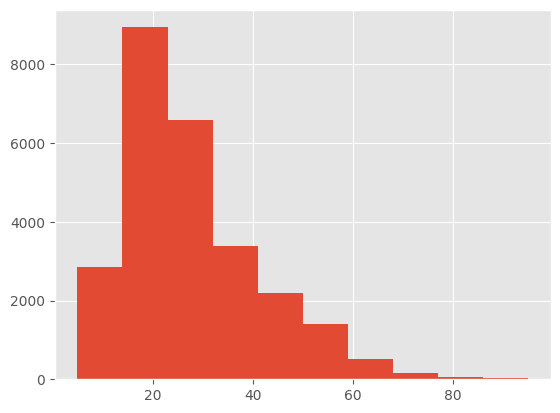

In [2]:
import gc
import os
import itertools
import pickle
import re
import time

import warnings
warnings.filterwarnings('ignore')

from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline

from functools import reduce
from tqdm import tqdm
from itertools import cycle
from scipy import stats
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import decomposition
from sklearn import tree

import lightgbm as lgb
import xgboost as xgb

pd.set_option("display.max_columns", None)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

pcp_df = pd.read_csv("./Dataset/to_predict.csv")
cl_df = pd.read_csv("./Dataset/CLdata.csv")
bs_df = pd.read_csv("./Dataset/BSinfo.csv")
ec_df  = pd.read_csv("./Dataset/ECdata.csv")
ss_df = pd.read_csv("./Dataset/SampleSubmission.csv")

pcp_df.shape, cl_df.shape, bs_df.shape, ec_df.shape, ss_df.shape

def rename_columns(df):
    df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)
    return df

pcp_df = rename_columns(pcp_df)
cl_df = rename_columns(cl_df)
bs_df = rename_columns(bs_df)
ec_df = rename_columns(ec_df)

cl_df['time'] = pd.to_datetime(cl_df['time'])
ec_df['time'] = pd.to_datetime(ec_df['time'])
pcp_df['time'] = pd.to_datetime(pcp_df['time'])

cl_bs_df = cl_df.merge(bs_df, on=['bs', 'cellname'], how='left')

cl_bs_df[cl_bs_df['bs'] == 'B_0']

cl_bs_df.groupby("bs")['cellname'].nunique()

cl_bs_df.groupby("bs")['cellname'].nunique().value_counts()

cl_bs_df = cl_bs_df.pivot(
    index=['time', 'bs'],
    columns=['cellname'],
    values=['load', 'esmode1', 'esmode2', 'esmode3',
       'esmode4', 'frequency',
       'bandwidth', 'antennas', 'txpower'],
).reset_index()

cl_bs_df.columns = ['_'.join([str(i) for i in x]) for x in cl_bs_df.columns]
cl_bs_df.columns = cl_bs_df.columns.str.strip('_')
cl_bs_df = rename_columns(cl_bs_df)
cl_bs_df = cl_bs_df.merge(bs_df.groupby('bs')[['rutype', 'mode']].first().reset_index(), on='bs', how='left')

df = cl_bs_df.merge(ec_df, on=['time', 'bs'], how='left')

df['split'] = df['energy'].isna().apply(lambda x: 'test' if x == True else 'train')

def plot_cat_train_test_dist(df, fe_name, hue='split'):

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Plot the distribution plot on the first subplot
    sns.countplot(data=df[df['split'] == 'train'], ax=axes[0], x=fe_name)
    axes[0].set_title('Train Count Plot')

    # Plot the box plot on the second subplot
    sns.countplot(data=df[df['split'] == 'test'], ax=axes[1], x=fe_name)
    axes[1].set_title('Test Count Plot')

    sns.countplot(data=df, ax=axes[2], x=fe_name, hue='split')
    axes[2].set_title('Train & Test Count Plot')

    plt.show()

df.groupby("split")['rutype'].value_counts().sort_index()

train_data = df[df['split'] =='train']
test_data = df[df['split'] =='test']

train_data.shape, test_data.shape

def feature_enginning(train_df, valid_df, test_df):

    train_df['hour'] = train_df['time'].dt.hour
    valid_df['hour'] = valid_df['time'].dt.hour
    test_df['hour'] = test_df['time'].dt.hour

    train_df['split'] = 'train'
    valid_df['split'] = 'valid'
    test_df['split'] = 'test'

    df = pd.concat([train_df, valid_df, test_df])
    df['bs_en'] = df['bs'].apply(lambda x: int(x.strip('B_')))

    # df['rutype'] = df['rutype'].apply(lambda x: int(x.strip('Type')))
    # df['mode'] = df['mode'].apply(lambda x: int(x.strip('Mode')))

    df = pd.get_dummies(df, columns=['rutype',  'mode', 'hour'])

    df.sort_values(['time', 'bs'], inplace=True)

    train_df = df[df['split'] =='train']
    valid_df = df[df['split'] =='valid']
    test_df = df[df['split'] =='test']

    return train_df, valid_df, test_df

import numpy as np
import pandas as pd
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn import model_selection, metrics

# Function for feature engineering
def feature_engineering(train_df, valid_df, test_df):
    train_df['hour'] = train_df['time'].dt.hour
    valid_df['hour'] = valid_df['time'].dt.hour
    test_df['hour'] = test_df['time'].dt.hour

    train_df['split'] = 'train'
    valid_df['split'] = 'valid'
    test_df['split'] = 'test'

    df = pd.concat([train_df, valid_df, test_df])
    df['bs_en'] = df['bs'].apply(lambda x: int(x.strip('B_')))

    df = pd.get_dummies(df, columns=['rutype',  'mode', 'hour'])

    df.sort_values(['time', 'bs'], inplace=True)

    train_df = df[df['split'] == 'train']
    valid_df = df[df['split'] == 'valid']
    test_df = df[df['split'] == 'test']

    return train_df, valid_df, test_df

# Define your dataset (train_data and test_data) and target column (target_col)
# ...

# Define columns to drop (if any)
target_col = 'energy'
drop_cols = ['time', 'bs', 'split', target_col]

kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

oof_valid_preds_lgb = np.zeros(train_data.shape[0])
oof_valid_preds_cb = np.zeros(train_data.shape[0])
test_preds_list_lgb = []
test_preds_list_cb = []

for i, (train_idx, valid_idx) in enumerate(kf.split(train_data)):
    train_df = train_data.iloc[train_idx]
    valid_df = train_data.iloc[valid_idx]
    test_df = test_data.copy()

    train_df, valid_df, test_df = feature_engineering(train_df=train_df, valid_df=valid_df, test_df=test_df)
    train_cols = [col for col in train_df.columns if col not in drop_cols]

    X_train, y_train = train_df[train_cols], train_df[target_col]
    X_valid, y_valid = valid_df[train_cols], valid_df[target_col]
    X_test = test_df[train_cols]

    # LightGBM model
    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'max_depth': -1,
        'metric': 'mae',
        'num_boost_round': 10000,
    }
    
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    
    early_stopping_callback = lgb.early_stopping(100, first_metric_only=True, verbose=False)
    verbose_callback = lgb.log_evaluation(100)
    
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[early_stopping_callback, verbose_callback],
    )

    valid_preds_lgb = lgb_model.predict(X_valid)
    test_preds_lgb = lgb_model.predict(X_test)

    # CatBoost model
    cb_params = {
        'iterations': 10000,
        'learning_rate': 0.1,
        'depth': 6,
        'loss_function': 'MAE',
        'verbose': 100,
    }

    cb_model = CatBoostRegressor(**cb_params)

    cb_model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        early_stopping_rounds=100,
        verbose=100,
    )

    valid_preds_cb = cb_model.predict(X_valid)
    test_preds_cb = cb_model.predict(X_test)

    # Ensembling - Simple Averaging
    valid_preds_ensemble = (valid_preds_lgb + valid_preds_cb) / 2
    test_preds_ensemble = (test_preds_lgb + test_preds_cb) / 2

    val_score = metrics.mean_absolute_error(y_valid, valid_preds_ensemble)
    oof_valid_preds_lgb[valid_idx] = valid_preds_lgb
    oof_valid_preds_cb[valid_idx] = valid_preds_cb
    test_preds_list_lgb.append(test_preds_lgb)
    test_preds_list_cb.append(test_preds_cb)

    print("=*"*50)
    print(f"Fold : {i}")
    print(f"Ensemble Valid score : ", val_score)

# Calculate the overall ensemble score
oof_score_lgb = metrics.mean_absolute_error(train_data[target_col], oof_valid_preds_lgb)
oof_score_cb = metrics.mean_absolute_error(train_data[target_col], oof_valid_preds_cb)
oof_score_ensemble = metrics.mean_absolute_error(train_data[target_col], (oof_valid_preds_lgb + oof_valid_preds_cb) / 2)

print("_-*"*50)
print(f"LightGBM OOF score: ", oof_score_lgb)
print(f"CatBoost OOF score: ", oof_score_cb)
print(f"Ensemble OOF score: ", oof_score_ensemble)

# test_preds_mean = np.mean(test_preds_list, axis=0)
test_preds_ensemble = (0.7*test_preds_lgb + 0.3*test_preds_cb)

test_preds_ensemble

test_data['Energy'] = test_preds_ensemble

test_data['Energy'].hist()

test_data['ID'] = test_data['time'].astype('str') + '_' + test_data['bs']

ss_df = ss_df[['ID']]
ss_df = ss_df.merge(test_data[['ID', 'Energy']], on='ID', how='left')

ss_df.to_csv("mid_submissionesmode_ensemble.csv", index=False) 